In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

from read_data.reading import read_reuters21578, HashTfidfVectoriser

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                                              compare_performance, plot_performance,\
                                              torch_algo_wrapper

In [2]:
def errors_at_time_t_over_inner_dim(V, r_range, t, algo_dict): 
    error_data  = {algo_name: [] for algo_name in algo_dict.keys()}

    for r in r_range:
        W_init, H_init = nmf.mult.update_empty_initials(V, r, None, None)
        for algo_name, algo in algo_dict.items():
            W, H = algo(V=V, inner_dim=r, 
                        record_errors=False,
                        time_limit=t,
                        max_steps=np.inf,
                        epsilon=0,
                        W_init=W_init.copy(),
                        H_init=H_init.copy()) 
            error = nmf.norms.norm_Frobenius(V - W@H)
            error_data[algo_name].append([r, error])
    return {k:np.array(v) for k,v in error_data.items()}


def plot_dict(dict_data, ax, log=False):
    for k,v in dict_data.items():
        ls = "--" if "torch" in k else "-"
        y_data = np.log(v[:, 1]) if log else v[:, 1] 
        ax.plot(v[:, 0], y_data, label=k, ls=ls)
    ax.legend()
    return ax

In [3]:
reuters_data = read_reuters21578("data/reuters21578", 
                                         vectorizer=HashTfidfVectoriser(12000))

data/reuters21578/reut2-000.sgm
data/reuters21578/reut2-001.sgm
data/reuters21578/reut2-002.sgm
data/reuters21578/reut2-003.sgm
data/reuters21578/reut2-004.sgm
data/reuters21578/reut2-005.sgm
data/reuters21578/reut2-006.sgm
data/reuters21578/reut2-007.sgm
data/reuters21578/reut2-008.sgm
data/reuters21578/reut2-009.sgm
data/reuters21578/reut2-010.sgm
data/reuters21578/reut2-011.sgm
data/reuters21578/reut2-012.sgm
data/reuters21578/reut2-013.sgm
data/reuters21578/reut2-014.sgm
data/reuters21578/reut2-015.sgm
data/reuters21578/reut2-016.sgm
data/reuters21578/reut2-017.sgm
data/reuters21578/reut2-018.sgm
data/reuters21578/reut2-019.sgm
data/reuters21578/reut2-020.sgm
data/reuters21578/reut2-021.sgm


In [4]:
reuters_data = reuters_data.toarray()

In [5]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [ ]:
errors_result = errors_at_time_t_over_inner_dim(
                            reuters_data,
                            range(20, 400, 20),
                            200, algo_dict_to_test)

<IPython.core.display.Javascript object>


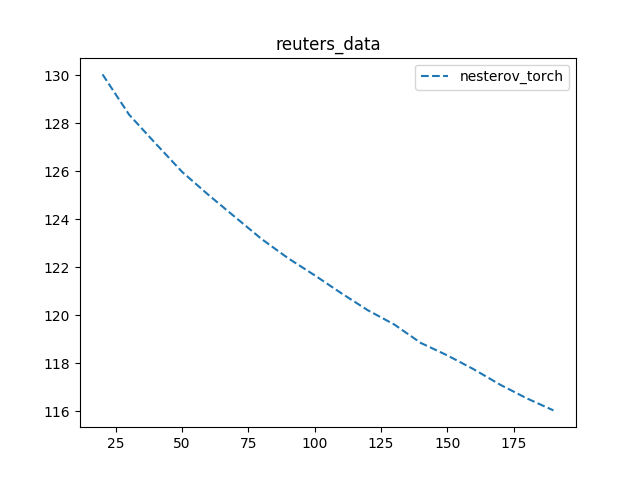

In [7]:
f, ax = plt.subplots()
ax.set_title("reuters_data")
plot_dict(errors_result, ax, log=False)

In [8]:
errors_result = errors_at_time_t_over_inner_dim(
                            reuters_data,
                            range(200, 400, 10),
                            200, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

<IPython.core.display.Javascript object>


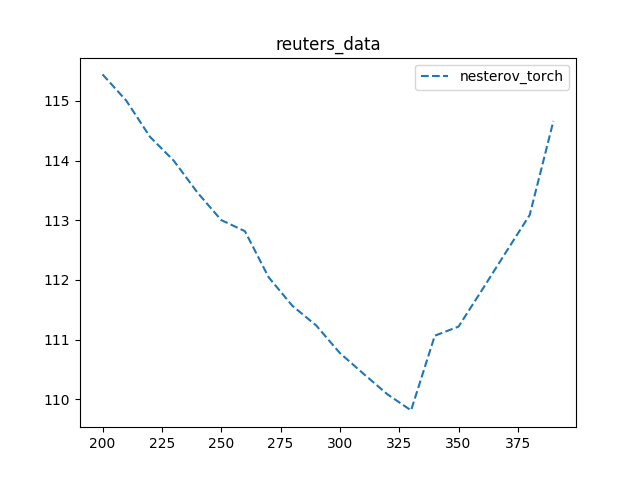

In [9]:
f, ax = plt.subplots()
ax.set_title("reuters_data")
plot_dict(errors_result, ax, log=False)